**Descripción del Dataset**

La base de datos escogida se llama “Synthetic Financial Datasets For Fraud Detection“ (Conjuntos de datos financieros sintéticos para la detección de fraudes), que figura en web Kaggle

**Variables**

Tiempo: representa una unidad de tiempo en el mundo real. En este caso, 1 tiempo equivale a 1 hora.

Tipo: Ingreso, Retiro, Débito, Pago y Transferencia.

Importe: Importe de la transacción.

nombre_origen: Cliente que inició la transacción.

balance_inicial_origen: Saldo inicial antes de la transacción.

nuevo_balance_origen: Nuevo saldo después de la transacción.

nombre_destino: Cliente que recibe la transacción.

balance_inicial_destino: Saldo inicial del receptor antes de la transacción.

nuevo_balance_destino: Saldo del receptor después de la transacción.

es_fraude: Se trata de las transacciones realizadas por los agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes busca obtener ganancias tomando el control de las cuentas de los clientes e intentando vaciar los fondos transfiriéndolos a otra cuenta y luego retirando el dinero del sistema.

es_fraude_marcado: El modelo de negocio busca controlar las transferencias masivas de una cuenta a otra y detectar los intentos ilegales. En este conjunto de datos, se considera intento ilegal transferir más de 200 000 en una sola transacción.

La variable es_fraude (variable objetivo) es el indicador que indica si las transacciones son fraude con el valor 1 o no, con el valor 0, mientras que es_fraude_marcado es lo que el sistema previene de la transacción debido a que se activan algunos umbrales.

**Objetivos**

Realizar una interpretacion de cada variable y como afecta para que la variable objetivo sea considerado fraude para, luego generar un modelo de prediccion que tome estos parametros como refrencia

CARGA DE LIBRERIAS

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

CARGA DE DATASET

In [2]:
df = pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')

# ANALISIS DATASET

In [3]:
print("Filas y columnas:", df.shape)


Filas y columnas: (6362620, 11)


In [4]:
print("\nPrimeras 5 filas:")
display(df.head())



Primeras 5 filas:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Renombramos al castellano para su mejor entendimiento

In [5]:
df.rename(columns={
    'step': 'tiempo',
    'type': 'tipo',
    'amount': 'monto',
    'nameOrig': 'nombre_origen',
    'oldbalanceOrg': 'balance_inicial_origen',
    'newbalanceOrig': 'nuevo_balance_origen',
    'nameDest': 'nombre_destino',
    'oldbalanceDest': 'balance_inicial_destino',
    'newbalanceDest': 'nuevo_balance_destino',
    'isFraud': 'es_fraude',
    'isFlaggedFraud': 'es_fraude_marcado'
}, inplace=True)
print("\nColumnas renombradas:")
display(df.columns)


Columnas renombradas:


Index(['tiempo', 'tipo', 'monto', 'nombre_origen', 'balance_inicial_origen',
       'nuevo_balance_origen', 'nombre_destino', 'balance_inicial_destino',
       'nuevo_balance_destino', 'es_fraude', 'es_fraude_marcado'],
      dtype='object')

In [6]:
df['tipo'] = df['tipo'].map({
    'PAYMENT': 'PAGO',
    'TRANSFER': 'TRANSFERENCIA',
    'CASH_OUT': 'RETIRO_EFECTIVO',
    'DEBIT': 'DEBITO',
    'CASH_IN': 'INGRESO_EFECTIVO'
})

print("\nValores traducidos en la columna 'tipo':")
display(df['tipo'].value_counts())


Valores traducidos en la columna 'tipo':


,count
tipo,
RETIRO_EFECTIVO,2237500
PAGO,2151495
INGRESO_EFECTIVO,1399284
TRANSFERENCIA,532909
DEBITO,41432


In [7]:
print("\nPrimeras 5 filas:")
display(df.head())


Primeras 5 filas:


,tiempo,tipo,monto,nombre_origen,balance_inicial_origen,nuevo_balance_origen,nombre_destino,balance_inicial_destino,nuevo_balance_destino,es_fraude,es_fraude_marcado
0,1,PAGO,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAGO,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFERENCIA,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,RETIRO_EFECTIVO,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAGO,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
print("\nInfo:")
df.info()



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tiempo                   int64  
 1   tipo                     object 
 2   monto                    float64
 3   nombre_origen            object 
 4   balance_inicial_origen   float64
 5   nuevo_balance_origen     float64
 6   nombre_destino           object 
 7   balance_inicial_destino  float64
 8   nuevo_balance_destino    float64
 9   es_fraude                int64  
 10  es_fraude_marcado        int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
print("\nResumen estadístico de variables numéricas:")
display(df.describe())


Resumen estadístico de variables numéricas:


,tiempo,monto,balance_inicial_origen,nuevo_balance_origen,balance_inicial_destino,nuevo_balance_destino,es_fraude,es_fraude_marcado
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Verificamos tipo de variable que contiene el dataset

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nVariables numéricas:", num_cols)
print("Variables categóricas:", cat_cols)



Variables numéricas: ['tiempo', 'monto', 'balance_inicial_origen', 'nuevo_balance_origen', 'balance_inicial_destino', 'nuevo_balance_destino', 'es_fraude', 'es_fraude_marcado']
Variables categóricas: ['tipo', 'nombre_origen', 'nombre_destino']


Valores faltantes

In [11]:
print("\nValores faltantes por columna:")
missing = df.isnull().sum()
print(missing[missing > 0])


Valores faltantes por columna:
Series([], dtype: int64)


OUTLIER

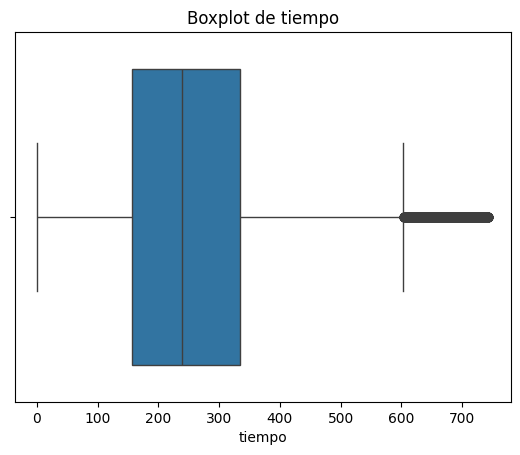

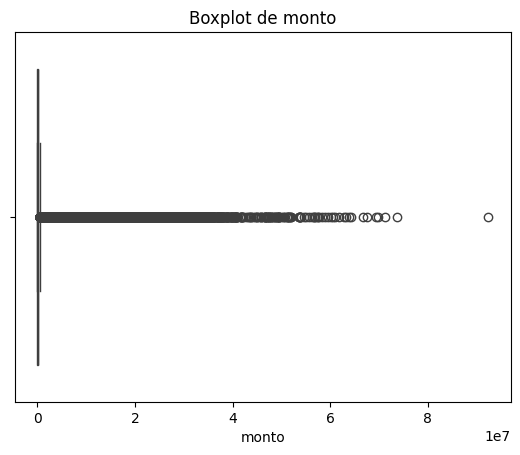

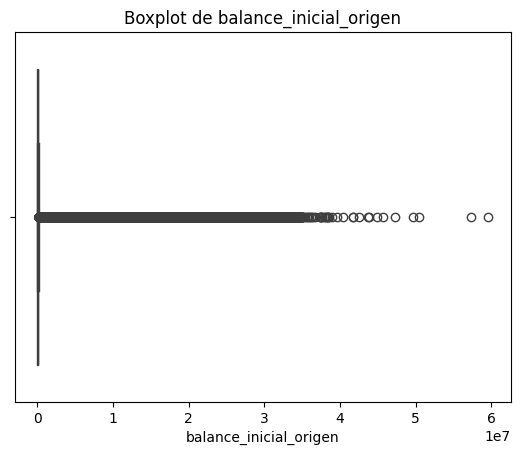

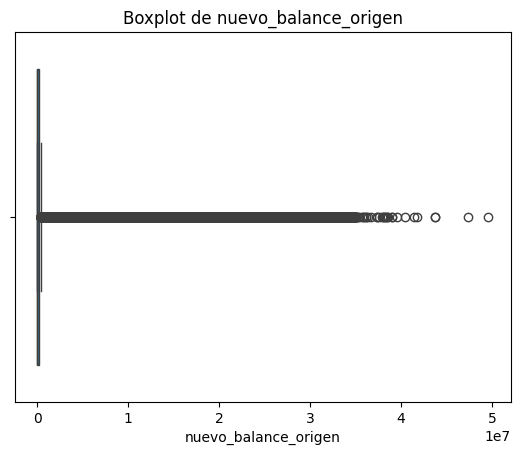

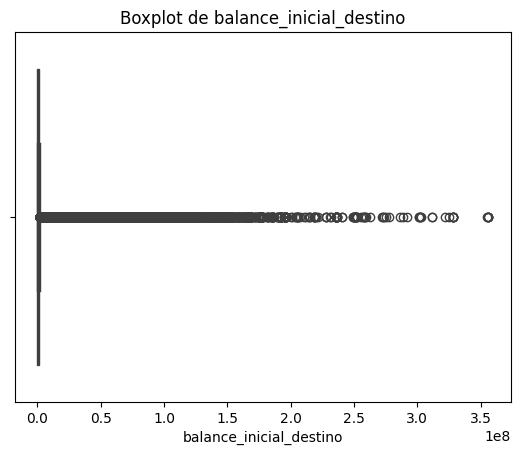

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [16]:
for col in num_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()


DISTRIBUCION DE VARIABLES

In [ ]:
print(df['tipo'].value_counts())
plt.rcParams['figure.figsize']=[20,10]
sns.countplot(x='tipo', data=df, order=df['tipo'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Distribución por tipo de transacción')

La mayoria de las operaciones sn de retiro de efectivo y pago

In [ ]:
for col in num_cols:
    plt.figure()
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


In [ ]:
for col in cat_cols:
    plt.figure()
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Cantidad de operaciones segun {col}')
    plt.xticks(rotation=45)
    plt.show()


ANALISIS UNIVARIADO

Analisis variable es fraude

In [ ]:
df_esfraude = df[(df['es_fraude'] == 1)]
df_esfraude

In [ ]:
total = df[(df['es_fraude'] == 1)]['tipo'].count()
print('Existen ', total, ' observaciones que son fraude')

In [ ]:
total = df['es_fraude'].value_counts()[0] + df['es_fraude'].value_counts()[1]
fraud = (df['es_fraude'].value_counts()[1]/total) * 100
print('Porcentaje de operaciones fraudulentas:', fraud)

In [ ]:
    for col in num_cols:
        plt.figure()
        sns.kdeplot(data=df, x=col, hue='es_fraude', common_norm=False)
        plt.title(f'Distribución de {col} según variable es_fraude')
        plt.show()


In [ ]:
print(df[(df['es_fraude'] == 1)]['tipo'].value_counts())

plt.figure(figsize=(20,10))
sns.countplot(x='tipo', data=df[(df['es_fraude'] == 1)], order=df[(df['es_fraude'] == 1)]['tipo'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Tipo de transacción cuando hay fraude')

Los casos de fraude se dan en operaciones de retiro de efectivo y transferencias

Analisis variable monto

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'es_fraude', y = 'monto', data = df[df.monto < 1e5])

Mientras mas alto el monto mayor casos de fraude

Analisis variable es_fraude_marcado

In [ ]:
df[(df['es_fraude_marcado'] == 1)]

Vemos que la operación es marcada cuando es un transferencia mayor a 200000

Verificacion de falsos positivos

In [ ]:
falso_positivo = df[(df['es_fraude_marcado'] == 1) & (df['es_fraude'] == 0)]

if falso_positivo.empty:
    print("No hay casos donde 'es_fraude_marcado' es 1 y 'es_fraude' es 0.")
else:
    print("Casos donde 'es_fraude_marcado' es 1 y 'es_fraude' es 0:")
    display(falso_positivo)

ANALISIS MULTIVARIADO

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de correlación")
plt.show()

Se puede observar una enorme correlacion entre las siguientes variables:

balance_inicial_destino y nuevo_balance_destino

balance_inicial_origeen y nuevo_balance_origen

Esta correlación es debida a la clara influencia que existen entre las variables. Por ejemplo, cuando se envia dinero a un destinatario, ese alguien aumenta su capital, mientras que el origen disminuye.

# MODELOS

Preparamos los datos

In [17]:
X = df.drop("es_fraude", axis=1) #Elimino de mi dataset la variable a predecir
y = df.es_fraude #Defino el target

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123, stratify=y)

In [19]:
print(X.shape, X_train.shape, X_test.shape)

(6362620, 10) (5090096, 10) (1272524, 10)


In [20]:
round(y.value_counts(normalize=True)*100,1)

,proportion
es_fraude,
0,99.9
1,0.1


Muy desbalanceada la base. Ver que hacer

In [29]:
# Eliminamos 'nombre_origen' and 'nombre_destino' que no vamos a tomar en cuenta para el modelo
X_train_processed = X_train.drop(['nombre_origen', 'nombre_destino'], axis=1)
X_test_processed = X_test.drop(['nombre_origen', 'nombre_destino'], axis=1)

# Cambiamos tipo de datos para ser utilizado en el modelo de clasificación
X_train_encoded = pd.get_dummies(X_train_processed, columns=['tipo'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test_processed, columns=['tipo'], drop_first=True)

In [22]:
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123, stratify=y)

In [23]:
print(X.shape, X_train_encoded.shape, X_test_encoded.shape)

(6362620, 10) (5090096, 10) (1272524, 10)


Utilizamos este metodo para definir los modelos con mejores rendimientos y trabajar sobre ellos en el tratamiento de hiperparametros

In [ ]:
pip install lazypredict

In [ ]:
# Importamos LazyClassifier
from lazypredict.Supervised import LazyClassifier

In [ ]:
lazy_clf= LazyClassifier(verbose=0,
					ignore_warnings=False,
					custom_metric=None)

# fitting datos en LazyClassifier
modelos, predictions = lazy_clf.fit(X_train_encoded, X_test_encoded,
							y_train, y_test)
modelos


In [ ]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="Accuracy", data=predictions)

Arbol de desicion

In [24]:
clf_tree = DecisionTreeClassifier()

In [25]:
clf_tree_sv = DecisionTreeClassifier(criterion='entropy', random_state=0)

In [30]:
clf_tree_sv.fit(X_train_encoded,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [31]:
prediciones = clf_tree_sv.predict(X_test_encoded)
prediciones

array([0, 0, 0, ..., 0, 0, 0])

Reporte de Metricas

In [32]:
print(classification_report(y_test,prediciones))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.89      0.88      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.94      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



Matriz de confusión

In [33]:
print(confusion_matrix(y_test,prediciones))

[[1270707     174]
 [    191    1452]]


Regresion logistica

In [34]:
modelo = LogisticRegression()

In [35]:
# Entrenamos el modelo con los datos encodeados
modelo.fit(X_train_encoded, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
# Hacemos las predicciones y tomamos la metrica "accuracy"
predicciones_rl = modelo.predict(X_train_encoded)
training_data_accuracy = accuracy_score(predicciones_rl, y_train)

In [37]:
print('Accuracy en datos de entrenamiento: ', training_data_accuracy)

Accuracy en datos de entrenamiento:  0.9982664374110036


In [38]:
# Metrica en datos de testeo
X_test_prediction = modelo.predict(X_test_encoded)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)

In [39]:
print('Accuracy en datos de testeo : ', test_data_accuracy)

Accuracy en datos de testeo :  0.9982727241293681


KNN

In [40]:
knn = KNeighborsClassifier(n_neighbors=1)

In [41]:
knn.fit(X_train_encoded,y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predicciones_knn = knn.predict(X_test_encoded)

In [ ]:
print(confusion_matrix(y_test,predicciones_knn))

Halving Grid Search

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15],  # Profundidad máxima
    'min_samples_split': [10, 20, 30],  # Número mínimo de muestras requeridas para dividir un nodo interno
     'min_samples_leaf': [5,9]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

clf_tree_cv = HalvingGridSearchCV(clf_tree, param_grid=param_grid, cv=5, min_resources=150, scoring='accuracy', n_jobs=-1, verbose=3)

clf_tree_cv.fit(X_train_encoded, y_train)

In [ ]:
y_train_pred = clf_tree_cv.predict(X_train_encoded) #Prediccion en datos de entrenamiento
y_test_pred = clf_tree_cv.predict(X_test_encoded) #Prediccion en datos de testeo
# Calcular la precisión
accuracy_tree = accuracy_score(y_test, y_test_pred)
print('DecisionTree Model accuracy score: {0:0.3f}'.format(accuracy_tree))

In [ ]:
# Obtener los scores de todas las combinaciones de parámetros
results = clf_tree_cv.cv_results_
results

# guardemos lo más importante dentro de un dataframe
df_clf_tree_cv = pd.DataFrame(results)

df_clf_tree_cv["mean_test_score_10%"]=accuracy_tree

df_clf_tree_cv = df_clf_tree_cv[['mean_train_score', 'mean_test_score',  "mean_test_score_10%" ,'params']]
df_clf_tree_cv= df_clf_tree_cv.round(3).sort_values("mean_test_score", ascending=False)[:1]
df_clf_tree_cv["model"]="DecisionTree"

df_clf_tree_cv